# OCR experiment

This notebook compares the OCR results embedded in the textbook scans to those of eric's api, and MS oxford alone

bash curl -H "Content-Type: application/json" -X POST -d '{"url":" http://dgmde20.com/img/lorem-ipsum-2.png"}' http://dev-ocr.ai2:/v1/ocr

In [84]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import pprint
import pickle
import json
import requests
import io

In [28]:
import pdfextraction.ocr_pipeline

In [43]:
# def query_vision_ocr(image_url):
#     api_entry_point = 'http://10.12.2.9:8000/v1/ocr'
#     header = {'Content-Type':'application/json'}
    
#     with open(page_image_path, 'rb') as f:
#         encoded_image_str = base64.b64encode(f.read())
        
#     request_data = {
#         'image': encoded_image_str
#         }
#     json_data = json.dumps(request_data)
# #     response = requests.post(api_entry_point, data=json_data, headers=header)
#     return json_data

In [20]:
li_image_url = 'http://dgmde20.com/img/lorem-ipsum-2.png'
image_url = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-pages-test/test_page.jpeg'

In [8]:
ocr_res = pdfextraction.ocr_pipeline.query_vision_ocr(image_url)

KeyboardInterrupt: 

In [134]:
# with open ('ocr_res.json', 'w') as f:
#     json.dump(ocr_res, f)

In [6]:
with open ('ocr_res.json', 'r') as f:
    ocr_res = json.load( f)

In [7]:
ocr_res

{u'detections': [{u'rectangle': [{u'x': 199, u'y': 362},
    {u'x': 1708, u'y': 522}],
   u'score': 0.75,
   u'value': u'Day Weekly Question Day Weekly Question How does a thermos work?'},
  {u'rectangle': [{u'x': 1980, u'y': 135}, {u'x': 2259, u'y': 464}],
   u'score': 0.75,
   u'value': u'scieoe ainy scien Big Idea 5'},
  {u'rectangle': [{u'x': 303, u'y': 2295}, {u'x': 340, u'y': 2333}],
   u'score': 1,
   u'value': u'1.'},
  {u'rectangle': [{u'x': 303, u'y': 2419}, {u'x': 343, u'y': 2457}],
   u'score': 1,
   u'value': u'2.'},
  {u'rectangle': [{u'x': 147, u'y': 212}, {u'x': 259, u'y': 255}],
   u'score': 1,
   u'value': u'Name'},
  {u'rectangle': [{u'x': 146, u'y': 651}, {u'x': 1806, u'y': 2053}],
   u'score': 0.75,
   u'value': u'One way to slow down the transfer of heat between objects is to keep them separated. This stops heat transfer by conduction, which requires that objects physically touch each other for heat to flow from one to the other. A second way to slow conduction is

In [153]:
for det in ocr_res['detections']:
    print(det['value'], '\n')

Day Weekly Question Day Weekly Question How does a thermos work? 

scieoe ainy scien Big Idea 5 

1. 

2. 

Name 

One way to slow down the transfer of heat between objects is to keep them separated. This stops heat transfer by conduction, which requires that objects physically touch each other for heat to flow from one to the other. A second way to slow conduction is by the use of insulators. Materials such as plastic, wood, and fabric are poor conductors of heat and therefore make good insulators. Air can work as an insulator as well. For example, Styrofoam® cups have tiny air pockets in the foam that keep heat from moving out or in A thermos is basically a bottle inside a bottle that limits heat conduction in both ways through the use of insulators and physical separation. The inner bottle, which is where you put your hot or cold drink has little contact with the outside. The only places where heat can travel are through the thermos cap and at points where the inner and outer walls 

In [19]:
point_to_tuple = lambda box: tuple(OrderedDict(sorted(box.items())).values())
get_bbox_tuples = lambda detection: map(point_to_tuple, detection['rectangle'])

In [15]:
def display_page(raw_page_img, page_layout):
    page_png_stream, y_height = make_png_stream(raw_page_img)
    page_img = make_open_cv_img(page_png_stream)
    for box in page_layout._objs:
        lr, ul = get_bbox_tuple(box, y_height)
        try:
            # print box.get_text()
            pass
        except AttributeError:
            pass
        cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    display(Image.fromarray(page_img, 'RGB'))


def draw_pdf_with_boxes(book_file, page_range, word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5):
    if page_range:
        page_range = map(lambda x: x - 1, page_range)
        suffix = '[{}-{}]'.format(page_range[0], page_range[1])
        raw_multi_pdf = WImage(filename=book_file + suffix)
    else:
        raw_multi_pdf = WImage(filename=book_file)
        
    doc_page_layouts = make_page_layouts(book_file, page_range,
                                         line_overlap,
                                         char_margin,
                                         line_margin,
                                         word_margin,
                                         boxes_flow)
    page_images = raw_multi_pdf.sequence
    for page_n in range(len(page_images)):
        display_page(page_images[page_n], doc_page_layouts[page_n])

In [16]:
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image

In [17]:
page_image_path = './page_sample.png'
with open(page_image_path, 'rb') as f:
        encoded_image_str = f.read()

In [25]:
req = requests.get(image_url)
tpi = Image.open(io.BytesIO(req.content))
# tpi.thumbnail((1000,1000))

In [8]:
def random_color():
    import random
    return random.randint(0,255), random.randint(0,255), random.randint(0,255)

In [26]:
pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

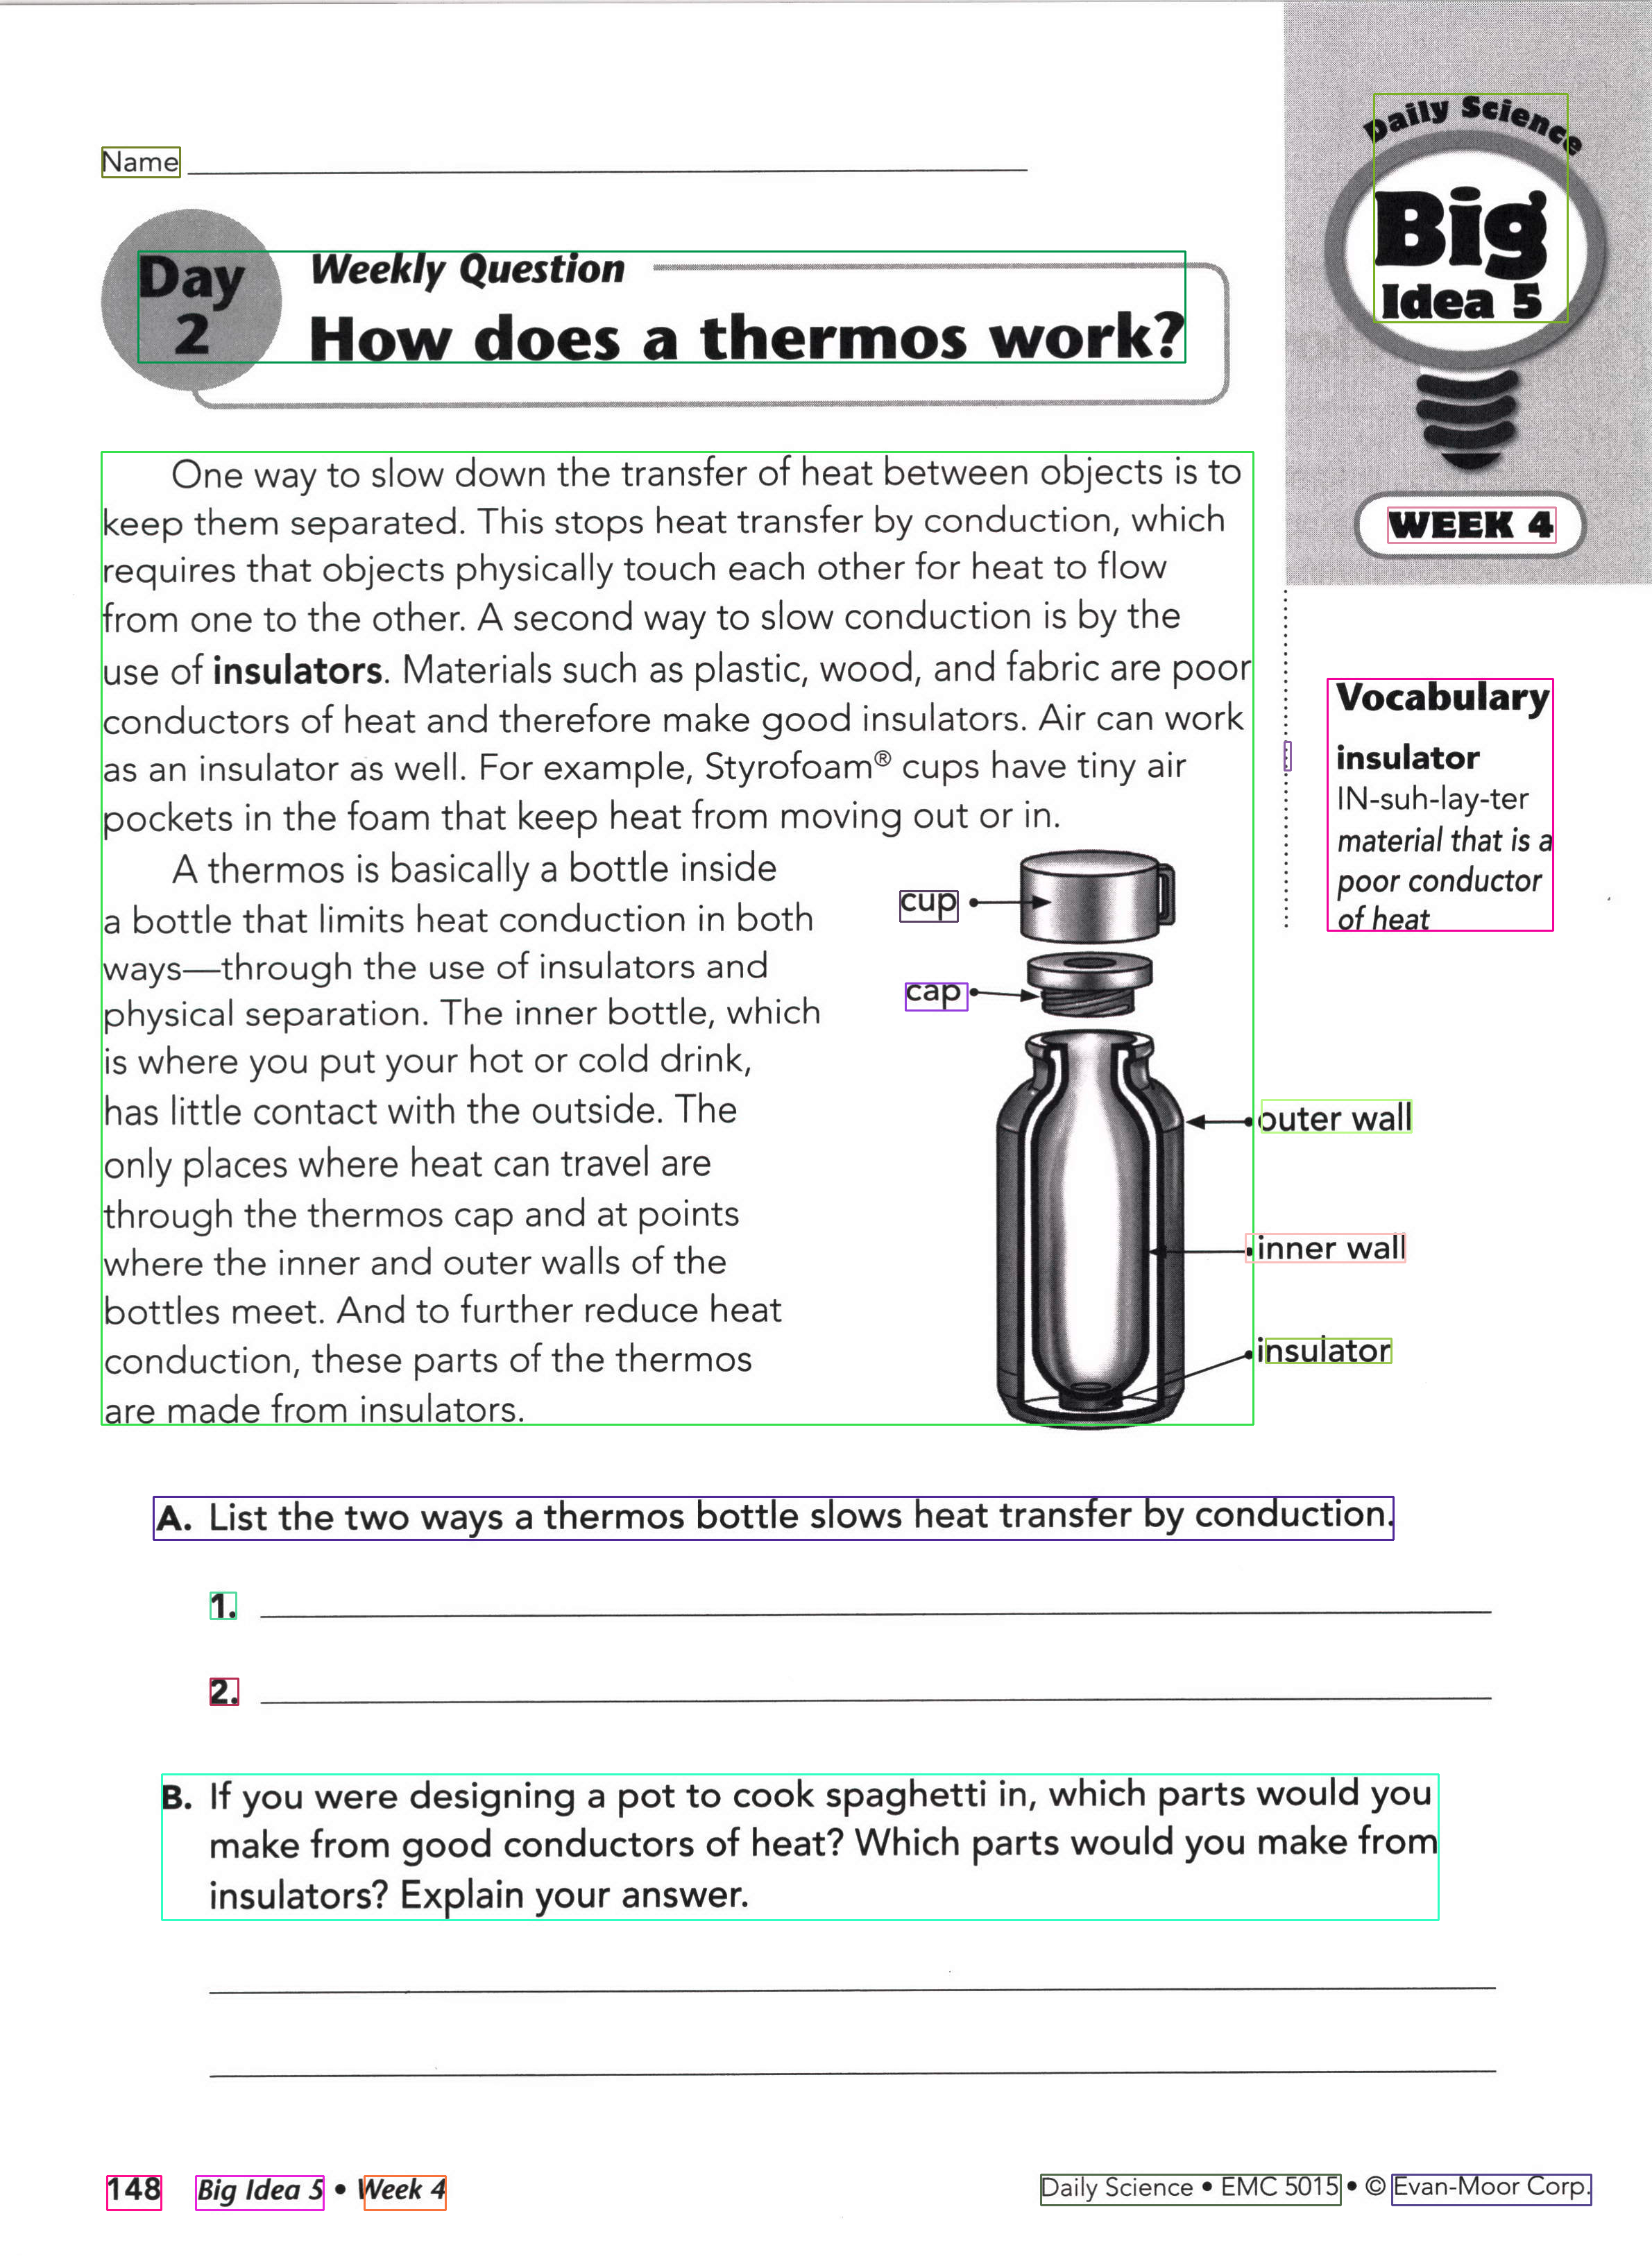

In [27]:
for box in ocr_res['detections']:
    lr, ul = get_bbox_tuples(box)
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))

In [10]:
import ordereddict

In [147]:
import jsonschema
from pdfextraction.annotation import page_schema

In [175]:
aj1 = json.loads(annotation_json)

validator = jsonschema.Draft4Validator(page_schema)
validator.validate(aj1)

In [176]:
pprint.pprint(aj1)

{u'text': {u'T1': {u'box_id': u'T1',
                   u'category': u'unlabeled',
                   u'contents': u'Day Weekly Question Day Weekly Question How does a thermos work?',
                   u'rectangle': [[199, 362], [1708, 522]],
                   u'score': 0.75,
                   u'source': {u'$schema': u'http://json-schema.org/draft-04/schema',
                               u'additionalProperties': False,
                               u'properties': [{u'book_source': u'sb'},
                                               {u'page_n': 149}],
                               u'type': u'object'}},
           u'T10': {u'box_id': u'T10',
                    u'category': u'unlabeled',
                    u'contents': u'cup',
                    u'rectangle': [[1297, 1284], [1380, 1328]],
                    u'score': 1,
                    u'source': {u'$schema': u'http://json-schema.org/draft-04/schema',
                                u'additionalProperties': False,
      

In [177]:
len(ocr_res['detections'])

21